In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
 
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
home_dir = '/content/drive/My Drive/Genetic Engineering Attribution Challenge/'

data_dir = home_dir + 'data/'
prepr_dir = home_dir + 'preprocessed/'
out_dir = home_dir + 'out/'

x_train = []
x_train.append(np.load(prepr_dir + 'train/ngrams.npy'))
x_train.append(np.load(prepr_dir + 'train/properties.npy'))

y = np.load(prepr_dir + 'train/y.npy')
y_ravel = np.load(prepr_dir + 'train/y_ravel.npy', allow_pickle=True)
classes = np.load(prepr_dir + 'train/y_classes.npy')

input_dims = [x.shape[1:] for x in x_train]
output_dim = classes.shape[0]
train_sample_num = x_train[0].shape[0]

print('Input dims: {}'.format(input_dims))
print('Output dim: {}'.format(output_dim))
print('Train sample_num: {}'.format(train_sample_num))

Input dims: [(4096,), (39,)]
Output dim: 1314
Train sample_num: 63017


In [ ]:
x_test = []
x_test.append(np.load(prepr_dir + 'test/ngrams.npy'))
x_test.append(np.load(prepr_dir + 'test/properties.npy'))

test_sample_num = x_test[0].shape[0]
print('Test sample num: {}'.format(test_sample_num))

Test sample num: 18816


In [ ]:
from keras.models import Model
from keras.layers import *
from keras import regularizers
 
def get_model(input_dims, output_dim):
    inputs = []
    outs = []

    kernel_reg = regularizers.l1_l2(l1=1e-5, l2=1e-5)
    bias_reg = regularizers.l2(1e-5)
    activity_reg = regularizers.l2(1e-5)
    
    # 6-gram counts
    x1 = Input(input_dims[0], name='ngram_counts')
    inputs.append(x1)
    x1 = Dense(2048,
               kernel_regularizer=kernel_reg,
               bias_regularizer=bias_reg,
               activity_regularizer=activity_reg)(x1)
    x1 = BatchNormalization()(x1)
    x1 = LeakyReLU(0.05)(x1)
    x1 = Dropout(0.5)(x1)
    
    # molecular properties
    x2 = Input(input_dims[1], name='molecular_properties')
    inputs.append(x2)
    x2 = Dense(512,
               kernel_regularizer=kernel_reg,
               bias_regularizer=bias_reg,
               activity_regularizer=activity_reg)(x2)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(0.05)(x2)
    x2 = Dropout(0.5)(x2)
 
    x = Concatenate()([x1, x2])
    x = Dense(2048,
              kernel_regularizer=kernel_reg,
              bias_regularizer=bias_reg,
              activity_regularizer=activity_reg)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.05)(x)
    x = Dropout(0.25)(x)
    x = Dense(output_dim, activation='softmax', name='softmax_outputs')(x)
    
    model = Model(inputs=inputs, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model
 
model = get_model(input_dims, output_dim)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ngram_counts (InputLayer)       [(None, 4096)]       0                                            
__________________________________________________________________________________________________
molecular_properties (InputLaye [(None, 39)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 2048)         8390656     ngram_counts[0][0]               
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          20480       molecular_properties[0][0]       
_______________________________________________________________________________________

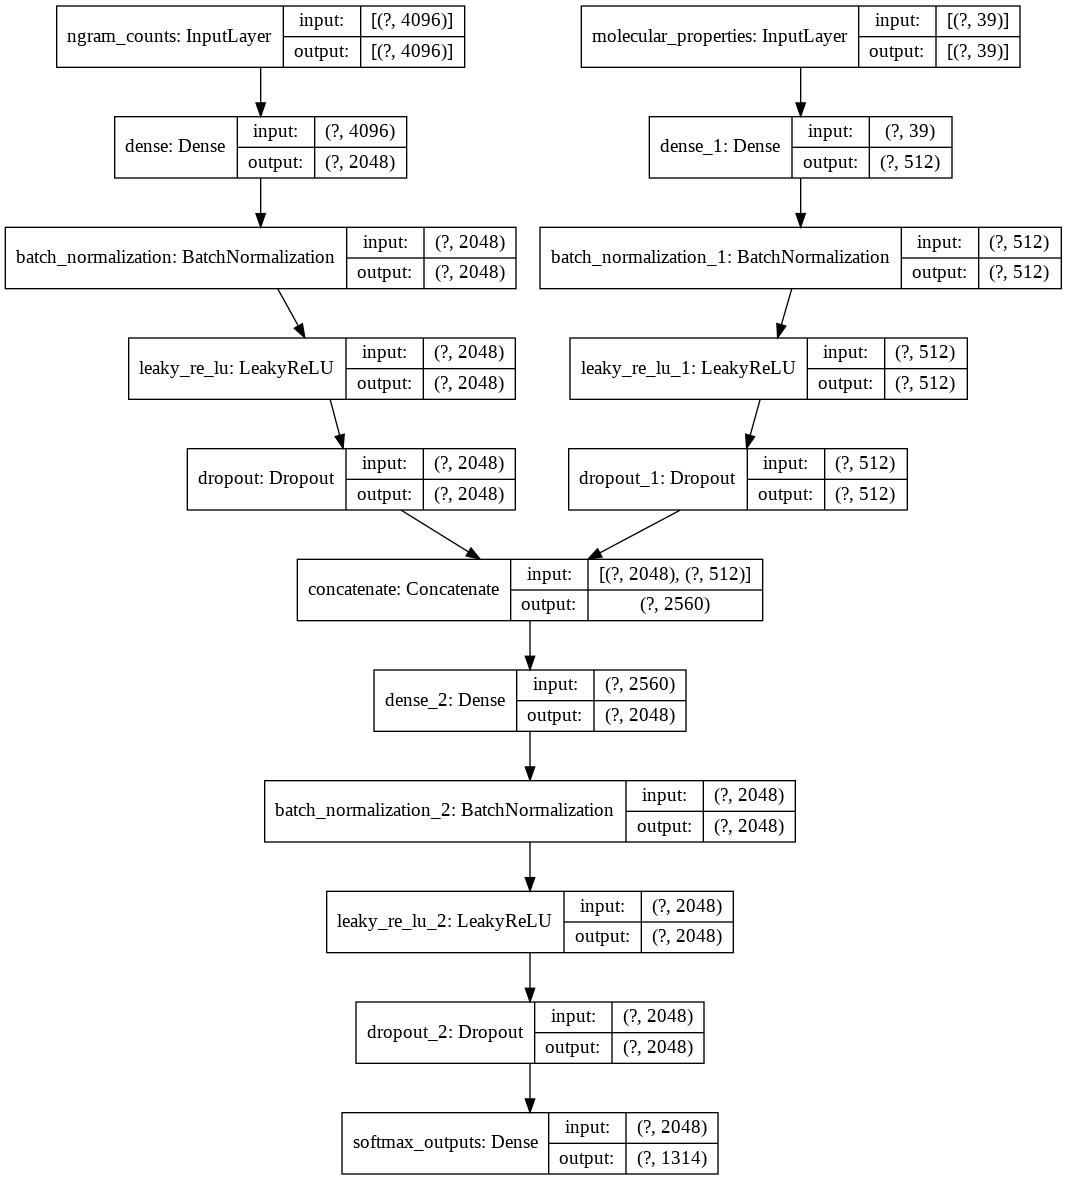

In [ ]:
from IPython.display import Image 
from keras.utils import plot_model

model_filename = out_dir + 'model.png'
plot_model(model, show_shapes=True, show_layer_names=True, to_file=model_filename)
Image(model_filename)

In [ ]:
# Generate train and validation indexes for K-fold
def generate_indexes(all_num, k_fold_num):
    # Use unused indexes as training ones
    first_train_indexes = []
    if all_num % k_fold_num != 0:
        first_train_indexes = list(range(all_num % k_fold_num))

    indexes = []
    val_num = int(all_num // k_fold_num)
 
    for i in range(k_fold_num):
        train_indexes = []
        train_indexes.extend(first_train_indexes)

        begin_index = i * val_num

        if len(first_train_indexes) > 0:
            begin_index += first_train_indexes[-1] + 1

        end_index = begin_index + val_num

        val_indexes = list(range(begin_index, end_index))
 
        for j in range(all_num):
            if j not in val_indexes and j not in train_indexes:
                train_indexes.append(j)
 
        indexes.append(tuple((train_indexes, val_indexes)))
 
    return indexes

# Train data custom generator
def train_gen(batch_size, indexes):
    i = 0
    
    while True:
        index_now = indexes[i]

        X_now = []
        X_now.append(x_train[0][index_now * batch_size: (index_now + 1) * batch_size, :])
        X_now.append(x_train[1][index_now * batch_size: (index_now + 1) * batch_size, :])
        y_now = y[index_now * batch_size: (index_now + 1) * batch_size, :]
        
        i += 1
        if i == len(indexes):
            i = 0
            
        yield X_now, y_now

# Validation data custom generator
def validation_gen(batch_size, indexes):
    i = 0
    
    while True:
        index_now = indexes[i]

        X_now = []
        X_now.append(x_train[0][index_now * batch_size: (index_now + 1) * batch_size, :])
        X_now.append(x_train[1][index_now * batch_size: (index_now + 1) * batch_size, :])
        
        i += 1
        if i == len(indexes):
            i = 0
            
        yield X_now

# Test data custom generator
def test_gen(batch_size, indexes):
    i = 0
    
    while True:
        index_now = indexes[i]

        X_now = []
        X_now.append(x_test[0][index_now * batch_size: (index_now + 1) * batch_size, :])
        X_now.append(x_test[1][index_now * batch_size: (index_now + 1) * batch_size, :])
        
        i += 1
        if i == len(indexes):
            i = 0
            
        yield X_now

In [ ]:
def top10_accuracy_scorer(probas, classes, y):
    """A custom scorer that evaluates a model on whether the correct label is in 
    the top 10 most probable predictions.

    Args:
        estimator (sklearn estimator): The sklearn model that should be evaluated.
        X (numpy array): The validation data.
        y (numpy array): The ground truth labels.

    Returns:
        float: Accuracy of the model as defined by the proportion of predictions
               in which the correct label was in the top 10. Higher is better.
    """
    
    # get the indices for top 10 predictions for each row; these are the last ten in each row
    # Note: We use argpartition, which is O(n), vs argsort, which uses the quicksort algorithm 
    # by default and is O(n^2) in the worst case. We can do this because we only need the top ten
    # partitioned, not in sorted order.
    # Documentation: https://numpy.org/doc/1.18/reference/generated/numpy.argpartition.html
    top10_idx = np.argpartition(probas, -10, axis=1)[:, -10:]
    
    # index into the classes list using the top ten indices to get the class names
    top10_preds = classes[top10_idx]

    # check if y-true is in top 10 for each set of predictions
    mask = top10_preds == y.reshape((y.size, 1))
    
    # take the mean
    top_10_accuracy = mask.any(axis=1).mean()
    return top_10_accuracy

In [ ]:
import tensorflow as tf

# Disable all TF warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
import gc
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss',
                               mode='min',
                               min_delta=1e-3,
                               patience=8,
                               baseline=None,
                               restore_best_weights=True,
                               verbose=1)
 
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              min_delta=1e-3,
                              factor=0.1,
                              patience=2,
                              min_lr=1e-6,
                              verbose=1)
 
kfold_num = 8
batch_size = 4096
epochs = 100

all_steps = int(np.ceil(train_sample_num / batch_size))
steps_per_epoch = all_steps - int(all_steps // kfold_num)
val_steps = all_steps - steps_per_epoch

test_steps = int(np.ceil(test_sample_num / batch_size))

indexes = generate_indexes(all_steps, kfold_num)

kfold_val_accs = []
kfold_test_preds = []

for i, (train_indexes, val_indexes) in enumerate(indexes):
    print('Model: {}'.format(i))
    model = get_model(input_dims, output_dim)
    model.fit(train_gen(batch_size, train_indexes),
              validation_data=train_gen(batch_size, val_indexes),
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=val_steps,
              callbacks=[reduce_lr, early_stopping],
              verbose=1)

    val_probas = model.predict_generator(validation_gen(batch_size, val_indexes),
                                         steps=val_steps, verbose=1)
    val_begin, val_end = int(val_indexes[0] * batch_size), int((val_indexes[-1] + 1) * batch_size)
    val_top10_acc = top10_accuracy_scorer(val_probas, classes, y_ravel[val_begin: val_end])
    kfold_val_accs.append(val_top10_acc)
    test_preds = model.predict_generator(test_gen(batch_size, range(0, test_steps)),
                                         steps=test_steps, verbose=1)
    kfold_test_preds.append(test_preds)
    print('Top-10 Accuracy: {:.6f}'.format(val_top10_acc))
    print('Mean Top-10 Accuracy: {:.6f}\n'.format(np.mean(kfold_val_accs)))
    gc.collect()  # Release unreferenced memory

Model: 0
Epoch 1/100
14/14 [==============================] - 3s 224ms/step - loss: 7.1580 - acc: 0.3230 - val_loss: 7.9013 - val_acc: 0.2933
Epoch 2/100
14/14 [==============================] - 3s 193ms/step - loss: 5.1986 - acc: 0.5086 - val_loss: 6.2400 - val_acc: 0.4364
Epoch 3/100
14/14 [==============================] - 3s 196ms/step - loss: 4.3185 - acc: 0.6030 - val_loss: 5.5472 - val_acc: 0.5332
Epoch 4/100
14/14 [==============================] - 3s 196ms/step - loss: 3.7986 - acc: 0.6707 - val_loss: 5.1101 - val_acc: 0.5580
Epoch 5/100
14/14 [==============================] - 3s 196ms/step - loss: 3.4479 - acc: 0.7167 - val_loss: 4.7259 - val_acc: 0.5728
Epoch 6/100
14/14 [==============================] - 3s 191ms/step - loss: 3.1609 - acc: 0.7603 - val_loss: 4.5288 - val_acc: 0.5879
Epoch 7/100
14/14 [==============================] - 3s 191ms/step - loss: 2.9805 - acc: 0.7824 - val_loss: 4.7105 - val_acc: 0.5696
Epoch 8/100
14/14 [==============================] - 3s 195m

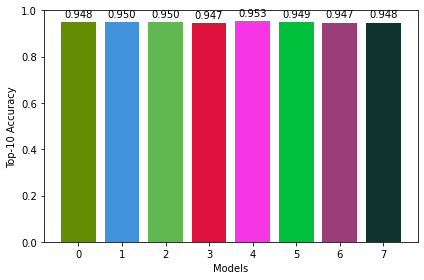

In [ ]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

fig, ax = plt.subplots()
colors = [[np.random.random(), np.random.random(), np.random.random(), 1.0] for _ in range(kfold_num)]
rects = ax.bar(list(range(kfold_num)), kfold_val_accs, color=colors)  # Keep alpha channel
ax.set_xlabel('Models');
ax.set_ylabel('Top-10 Accuracy')
autolabel(rects)
fig.tight_layout()
plt.show()

In [ ]:
'{:.6f}'.format(np.mean(kfold_val_accs))

'0.948961'

In [ ]:
probas = np.mean(np.array(kfold_test_preds), axis=0)
probas[0]

array([3.8367152e-12, 1.2770635e-11, 1.9753844e-11, ..., 6.1286844e-11,
       2.8420365e-11, 5.4992347e-11], dtype=float32)

In [ ]:
submission_format = pd.read_csv(data_dir + 'submission_format.csv', index_col='sequence_id')
submission_format.head()

,00Q4V31T,012VT4JK,028IO5W2,03GRNN7N,03Y3W51H,09MQV1TY,0A4AHRCT,0A9M05NC,0B9GCUVV,0CL7QVG8,0CML4B5I,0DTHTJLJ,0FFBBVE1,0HWCWFNU,0L3Y6ZB2,0M44GDO8,0MDYJM3H,0N3V9P9M,0NP55E93,0PJ91ZT6,0R296F9R,0T2AZBD6,0URA80CN,0VRP2DI6,0W6O08VX,0WHP4PPK,0XPTGGLP,0XS4FHP3,0Y24J5G2,10TEBWK2,11TTDKTM,131RRHBV,13LZE1F7,14PBN8C2,15D0Z97U,15S88O4Q,18C9J8EH,19CAUKJB,1AP294AT,1B9BJ2IP,...,Z1C99MVU,Z1Y066QU,Z6LWLWFZ,Z7YFK3I0,Z7ZKDLZG,Z80NVAXF,Z8BWVZZX,ZAYLY2YU,ZB6DPIG5,ZB862XHR,ZBQD50GN,ZC07UYVV,ZCU48L3S,ZEAZQ1QQ,ZEB7PDQK,ZEBTRK7D,ZEJOQQJF,ZELU1VMX,ZFBSIW7Q,ZGY1YZ7P,ZH6LR5MO,ZIGUIE0J,ZIJRW95G,ZK6YBV02,ZLSXM0KN,ZMCRIYYJ,ZMEZU4BS,ZMUIMBDX,ZOI7FJEN,ZQ5A6IY9,ZQNGGY33,ZSHS4VJZ,ZT1IP3T6,ZU6860XU,ZU6TVFFU,ZU75P59K,ZUI6TDWV,ZWFD8OHC,ZX06ZDZN,ZZJVE4HO
sequence_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
E0VFT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTRK5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2Z7FZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VJI6E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
721FI,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
assert submission_format.shape == probas.shape
assert (classes == submission_format.columns).all()

In [ ]:
my_submission = pd.DataFrame(data=probas, 
                             columns=classes, 
                             index=submission_format.index)
my_submission.head()

,00Q4V31T,012VT4JK,028IO5W2,03GRNN7N,03Y3W51H,09MQV1TY,0A4AHRCT,0A9M05NC,0B9GCUVV,0CL7QVG8,0CML4B5I,0DTHTJLJ,0FFBBVE1,0HWCWFNU,0L3Y6ZB2,0M44GDO8,0MDYJM3H,0N3V9P9M,0NP55E93,0PJ91ZT6,0R296F9R,0T2AZBD6,0URA80CN,0VRP2DI6,0W6O08VX,0WHP4PPK,0XPTGGLP,0XS4FHP3,0Y24J5G2,10TEBWK2,11TTDKTM,131RRHBV,13LZE1F7,14PBN8C2,15D0Z97U,15S88O4Q,18C9J8EH,19CAUKJB,1AP294AT,1B9BJ2IP,...,Z1C99MVU,Z1Y066QU,Z6LWLWFZ,Z7YFK3I0,Z7ZKDLZG,Z80NVAXF,Z8BWVZZX,ZAYLY2YU,ZB6DPIG5,ZB862XHR,ZBQD50GN,ZC07UYVV,ZCU48L3S,ZEAZQ1QQ,ZEB7PDQK,ZEBTRK7D,ZEJOQQJF,ZELU1VMX,ZFBSIW7Q,ZGY1YZ7P,ZH6LR5MO,ZIGUIE0J,ZIJRW95G,ZK6YBV02,ZLSXM0KN,ZMCRIYYJ,ZMEZU4BS,ZMUIMBDX,ZOI7FJEN,ZQ5A6IY9,ZQNGGY33,ZSHS4VJZ,ZT1IP3T6,ZU6860XU,ZU6TVFFU,ZU75P59K,ZUI6TDWV,ZWFD8OHC,ZX06ZDZN,ZZJVE4HO
sequence_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
E0VFT,3.836715e-12,1.277064e-11,1.975384e-11,1.912615e-12,9.309197e-09,9.248750e-11,2.499341e-11,1.803373e-08,3.834775e-10,1.767669e-08,2.348565e-11,1.706280e-10,2.705261e-10,4.885584e-10,1.329953e-11,1.581493e-12,3.834036e-12,5.613230e-11,3.451133e-09,1.868892e-09,1.793346e-11,3.232464e-10,9.716600e-10,1.712293e-10,5.210969e-10,1.155546e-09,1.084536e-09,5.607548e-12,1.924253e-11,1.502595e-11,5.441605e-11,1.464326e-11,1.697594e-12,3.664281e-10,3.506490e-10,1.933686e-11,1.094110e-10,8.420077e-11,8.224688e-11,4.964540e-13,...,7.968325e-09,3.118558e-12,4.318342e-11,8.540633e-12,7.160747e-11,1.307673e-10,2.178746e-12,3.642886e-11,6.453520e-12,2.223959e-10,2.935997e-10,6.406730e-12,3.769216e-09,1.075854e-09,3.181011e-11,3.567449e-11,2.984612e-10,3.591604e-11,1.226881e-09,6.125717e-11,2.642742e-12,1.115372e-11,1.122281e-08,1.074941e-10,1.206244e-09,3.103458e-10,2.776025e-11,1.090120e-10,3.895385e-11,1.632682e-12,1.265978e-11,1.008144e-11,5.462504e-11,8.054420e-11,5.572504e-10,7.574961e-11,4.947595e-10,6.128684e-11,2.842037e-11,5.499235e-11
TTRK5,7.740097e-10,9.497387e-12,6.637154e-10,3.430071e-10,6.825656e-09,8.654406e-10,7.729975e-11,6.380377e-08,6.337622e-10,1.748813e-10,3.328384e-11,2.878416e-10,1.394407e-10,2.316382e-09,1.579644e-10,2.024534e-09,7.034548e-10,2.393214e-09,2.871422e-09,3.006169e-09,1.114656e-10,3.980646e-10,5.459398e-09,9.581232e-10,3.311394e-08,5.981152e-10,3.322072e-09,2.687400e-11,3.317489e-10,1.621404e-09,2.831315e-09,7.163458e-10,2.179219e-10,1.820102e-08,3.323799e-10,1.338610e-10,1.217143e-10,5.942559e-10,1.369388e-08,1.069192e-10,...,1.208910e-09,3.070096e-10,1.568192e-09,9.132986e-10,9.473915e-10,3.757196e-10,3.108332e-10,3.969997e-09,5.431524e-10,1.436460e-09,4.916785e-11,7.203799e-09,1.269634e-09,1.087347e-08,2.992068e-09,1.753848e-09,3.865873e-09,8.952208e-10,8.913334e-10,2.106188e-08,6.922916e-11,2.056198e-10,1.070626e-09,9.980758e-09,3.052445e-08,1.171790e-09,1.044509e-10,8.811641e-09,8.588877e-10,1.167505e-08,7.960351e-09,7.243995e-10,3.022302e-10,1.866071e-10,3.874452e-09,7.879202e-09,1.592265e-10,5.514102e-07,4.150939e-11,2.056501e-10
2Z7FZ,2.220882e-08,4.480112e-09,5.291468e-08,2.446612e-08,5.196583e-08,3.378411e-05,1.825596e-04,1.007974e-06,2.664621e-08,1.607166e-07,2.972245e-07,2.691626e-07,4.305786e-09,3.396732e-09,1.663736e-08,2.434298e-07,7.898420e-07,7.624284e-07,2.586652e-06,1.278570e-05,6.277944e-09,8.680371e-07,1.801346e-08,1.148730e-06,2.279456e-07,2.401773e-05,1.879956e-07,4.933013e-09,2.413625e-07,2.377519e-06,1.537919e-04,1.954028e-08,2.928249e-09,4.188557e-08,1.040679e-07,1.073327e-07,3.339546e-06,3.279893e-07,2.553119e-07,4.761720e-10,...,2.229319e-07,3.426579e-07,1.059830e-09,2.254841e-07,1.711264e-05,2.177448e-06,2.355835e-09,4.031243e-08,1.227315e-07,1.460754e-08,3.661310e-07,9.841972e-05,8.753470e-07,9.959326e-04,1.607041e-08,7.080248e-07,6.171467e-08,9.992422e-09,4.620471e-08,5.663315e-09,2.659952e-10,2.588663e-09,4.422222e-06,9.397970e-08,8.164874e-09,1.806689e-07,9.103194e-08,1.560394e-08,8.503940e-07,2.117402e-08,3.202803e-07,1.534041e-06,3.135820e-09,1.563122e-07,2.334273e-05,2.286407e-06,1.262982e-07,5.643211e-08,8.339543e-09,2.194220e-06
VJI6E,2.401170e-08,1.828703e-08,

In [ ]:
my_submission.to_csv(out_dir + 'submission.csv')